In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

In [2]:
train = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0')
val = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
test = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')

pbe_train = pd.DataFrame(data=[train['PBE Prediction'], train['PBE Target']]).transpose().dropna()
pbe_val = pd.DataFrame(data=[val['PBE Prediction'], val['PBE Target']]).transpose().dropna()
pbe_test = pd.DataFrame(data=[test['PBE Prediction'], test['PBE Target']]).transpose().dropna()

train = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0')
val = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
test = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')

scan_train = pd.DataFrame(data=[train['SCAN Prediction'], train['SCAN Target']]).transpose().dropna()
scan_val = pd.DataFrame(data=[val['SCAN Prediction'], val['SCAN Target']]).transpose().dropna()
scan_test = pd.DataFrame(data=[test['SCAN Prediction'], test['SCAN Target']]).transpose().dropna()

In [3]:
csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')

csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0').clip(lower=0, upper=100)

csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)
vss_hfx_df = vss_hfx_df.clip(lower=0, upper=100)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

from scipy.interpolate import interp1d

def pred_energy(structure, functional, dataset, pred_df):
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    else:
        raise ValueError("Specify a valid dataset!")
    pred_hfx = pred_df.loc[structure][f'{functional.upper()} Prediction']
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

pbe_train['predicted SSE'] = [pred_energy(structure, 'pbe', 'vss', pred_df=pbe_train) for structure in pbe_train.index]
pbe_train['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in pbe_train.index]
pbe_val['predicted SSE'] = [pred_energy(structure, 'pbe', 'vss', pred_df=pbe_val) for structure in pbe_val.index]
pbe_val['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in pbe_val.index]
pbe_test['predicted SSE'] = [pred_energy(structure, 'pbe', 'csd', pred_df=pbe_test) for structure in pbe_test.index]
pbe_test['target SSE'] = [csd_76['dlpno-CCSD_T.vertsse'][structure] for structure in pbe_test.index]

scan_train['predicted SSE'] = [pred_energy(structure, 'scan', 'vss', pred_df=scan_train) for structure in scan_train.index]
scan_train['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in scan_train.index]
scan_val['predicted SSE'] = [pred_energy(structure, 'scan', 'vss', pred_df=scan_val) for structure in scan_val.index]
scan_val['target SSE'] = [vss_452['dlpno-CCSD_T.vertsse'][structure] for structure in scan_val.index]
scan_test['predicted SSE'] = [pred_energy(structure, 'scan', 'csd', pred_df=scan_test) for structure in scan_test.index]
scan_test['target SSE'] = [csd_76['dlpno-CCSD_T.vertsse'][structure] for structure in scan_test.index]

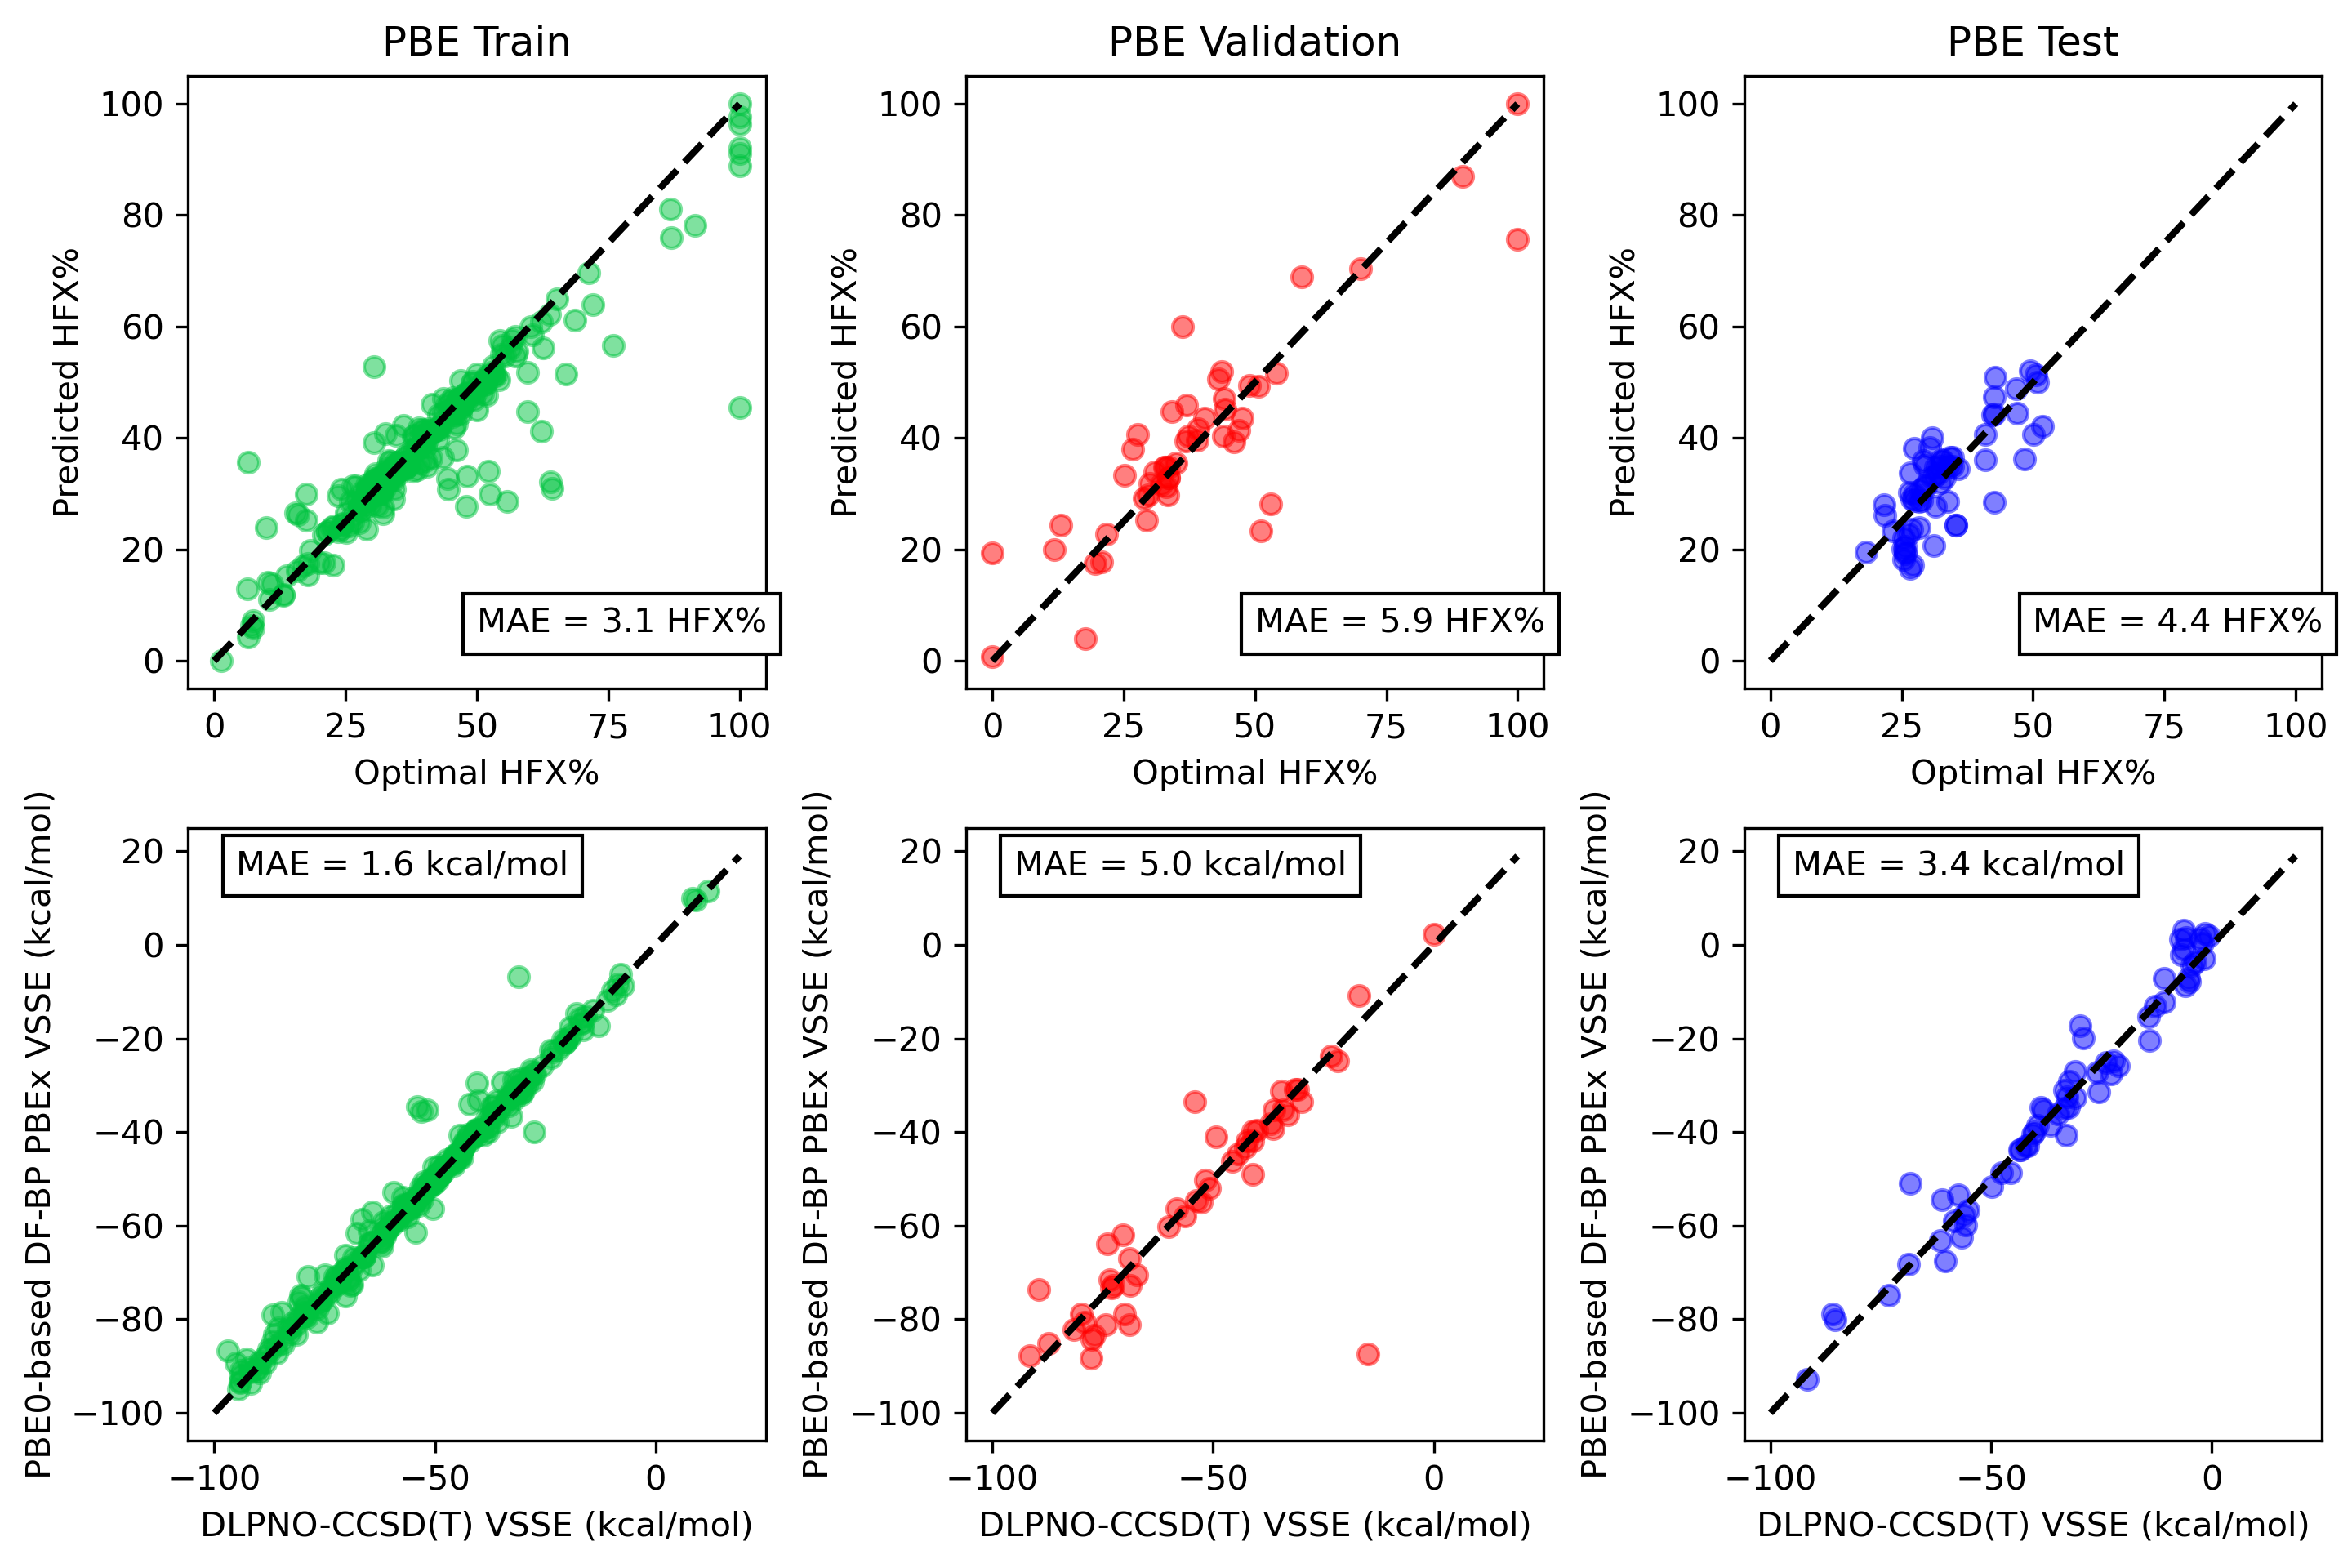

In [4]:
pts = np.arange(0, 101, 1)
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(9.75, 6.5), dpi=300)
ax[0,0].set_title('PBE Train')
ax[0,0].set_xlabel('Optimal HFX%')
ax[0,0].set_ylabel('Predicted HFX%')
ax[0,1].set_title('PBE Validation')
ax[0,1].set_xlabel('Optimal HFX%')
ax[0,1].set_ylabel('Predicted HFX%')
ax[0,2].set_title('PBE Test')
ax[0,2].set_xlabel('Optimal HFX%')
ax[0,2].set_ylabel('Predicted HFX%')


ax[0,0].scatter(pbe_train['PBE Target'], pbe_train['PBE Prediction'], color='#00C440', alpha=0.5)
ax[0,0].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0,0].text(50, 5, f'MAE = {np.abs(np.array(pbe_train["PBE Target"])-np.array(pbe_train["PBE Prediction"])).mean():1.1f} HFX%', bbox=dict(edgecolor='black', facecolor='white'))

ax[0,1].scatter(pbe_val['PBE Target'], pbe_val['PBE Prediction'], color='#FF0000', alpha=0.5)
ax[0,1].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0,1].text(50, 5, f'MAE = {np.abs(np.array(pbe_val["PBE Target"])-np.array(pbe_val["PBE Prediction"])).mean():1.1f} HFX%', bbox=dict(edgecolor='black', facecolor='white'))

ax[0,2].scatter(pbe_test['PBE Target'], pbe_test['PBE Prediction'], color='#0000FF', alpha=0.5)
ax[0,2].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0,2].text(50, 5, f'MAE = {np.abs(np.array(pbe_test["PBE Target"])-np.array(pbe_test["PBE Prediction"])).mean():1.1f} HFX%', bbox=dict(edgecolor='black', facecolor='white'))

pts = np.arange(0, 101, 1)
#ax[1,0].set_title('PBE Train')
ax[1,0].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[1,0].set_ylabel('PBE0-based DF-BP PBEx VSSE (kcal/mol)')
#ax[1,1].set_title('PBE Validation')
ax[1,1].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[1,1].set_ylabel('PBE0-based DF-BP PBEx VSSE (kcal/mol)')
#ax[1,2].set_title('PBE Test')
ax[1,2].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[1,2].set_ylabel('PBE0-based DF-BP PBEx VSSE (kcal/mol)')

ax[1,0].scatter(pbe_train['target SSE'], pbe_train['predicted SSE'], color='#00C440', alpha=0.5)
ax[1,1].scatter(pbe_val['target SSE'], pbe_val['predicted SSE'], color='#FF0000', alpha=0.5)
ax[1,2].scatter(pbe_test['target SSE'], pbe_test['predicted SSE'], color='#0000FF', alpha=0.5)

pts = np.arange(-100, 20, 1)

ax[1,0].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1,0].text(-95, 15, f'MAE = {np.abs(np.array(pbe_train["target SSE"])-np.array(pbe_train["predicted SSE"])).mean():1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

ax[1,1].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1,1].text(-95, 15, f'MAE = {np.abs(np.array(pbe_val["target SSE"])-np.array(pbe_val["predicted SSE"])).mean():1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

ax[1,2].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1,2].text(-95, 15, f'MAE = {np.abs(np.array(pbe_test["target SSE"])-np.array(pbe_test["predicted SSE"])).mean():1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

fig.tight_layout()

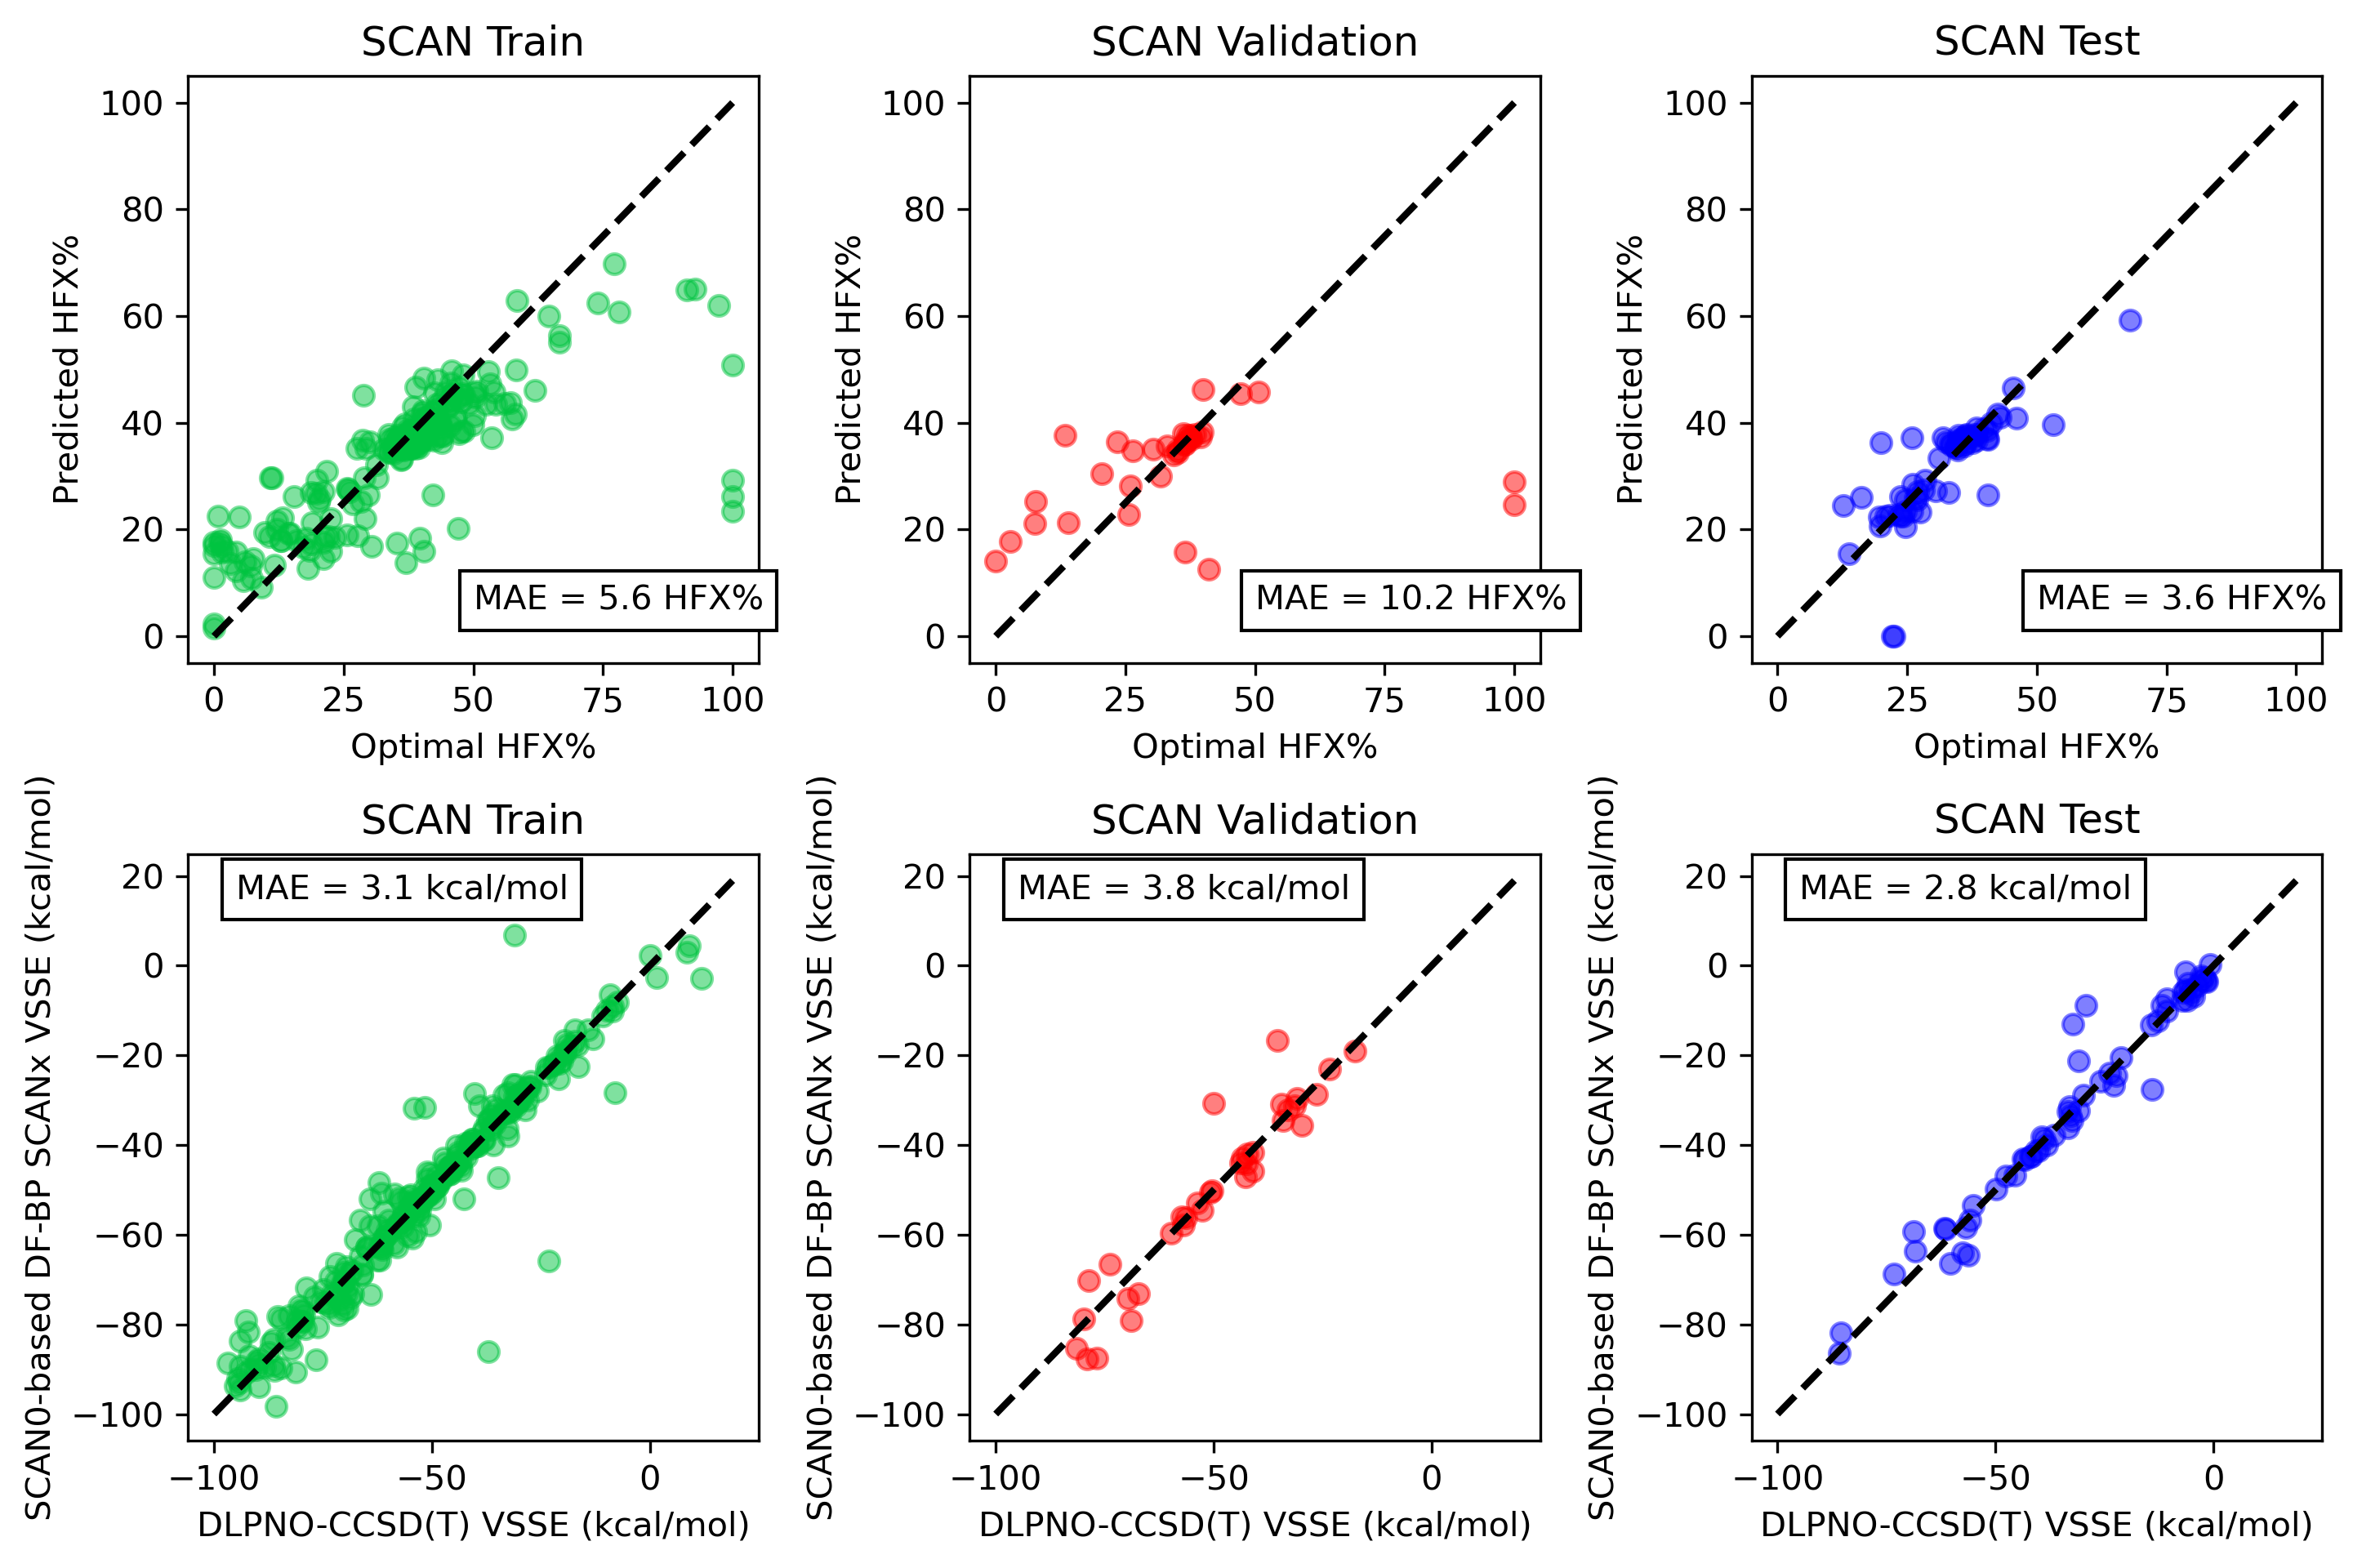

In [5]:
#SCAN0 model - SI

pts = np.arange(0, 101, 1)
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(9.75, 6.5), dpi=300)

ax[0,0].set_title('SCAN Train')
ax[0,0].set_xlabel('Optimal HFX%')
ax[0,0].set_ylabel('Predicted HFX%')
ax[0,1].set_title('SCAN Validation')
ax[0,1].set_xlabel('Optimal HFX%')
ax[0,1].set_ylabel('Predicted HFX%')
ax[0,2].set_title('SCAN Test')
ax[0,2].set_xlabel('Optimal HFX%')
ax[0,2].set_ylabel('Predicted HFX%')

ax[0,0].scatter(scan_train['SCAN Target'], scan_train['SCAN Prediction'], color='#00C440', alpha=0.5)
ax[0,0].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0,0].text(50, 5, f'MAE = {np.abs(np.array(scan_train["SCAN Target"])-np.array(scan_train["SCAN Prediction"])).mean():1.1f} HFX%', bbox=dict(edgecolor='black', facecolor='white'))

ax[0,1].scatter(scan_val['SCAN Target'], scan_val['SCAN Prediction'], color='#FF0000', alpha=0.5)
ax[0,1].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0,1].text(50, 5, f'MAE = {np.abs(np.array(scan_val["SCAN Target"])-np.array(scan_val["SCAN Prediction"])).mean():1.1f} HFX%', bbox=dict(edgecolor='black', facecolor='white'))

ax[0,2].scatter(scan_test['SCAN Target'], scan_test['SCAN Prediction'], color='#0000FF', alpha=0.5)
ax[0,2].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[0,2].text(50, 5, f'MAE = {np.abs(np.array(scan_test["SCAN Target"])-np.array(scan_test["SCAN Prediction"])).mean():1.1f} HFX%', bbox=dict(edgecolor='black', facecolor='white'))

pts = np.arange(-100, 20, 1)
ax[1,0].set_title('SCAN Train')
ax[1,0].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[1,0].set_ylabel('SCAN0-based DF-BP SCANx VSSE (kcal/mol)')
ax[1,1].set_title('SCAN Validation')
ax[1,1].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[1,1].set_ylabel('SCAN0-based DF-BP SCANx VSSE (kcal/mol)')
ax[1,2].set_title('SCAN Test')
ax[1,2].set_xlabel('DLPNO-CCSD(T) VSSE (kcal/mol)')
ax[1,2].set_ylabel('SCAN0-based DF-BP SCANx VSSE (kcal/mol)')

ax[1,0].scatter(scan_train['target SSE'], scan_train['predicted SSE'], color='#00C440', alpha=0.5)
ax[1,1].scatter(scan_val['target SSE'], scan_val['predicted SSE'], color='#FF0000', alpha=0.5)
ax[1,2].scatter(scan_test['target SSE'], scan_test['predicted SSE'], color='#0000FF', alpha=0.5)

ax[1,0].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1,0].text(-95, 15, f'MAE = {np.abs(np.array(scan_train["target SSE"])-np.array(scan_train["predicted SSE"])).mean():1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

ax[1,1].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1,1].text(-95, 15, f'MAE = {np.abs(np.array(scan_val["target SSE"])-np.array(scan_val["predicted SSE"])).mean():1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

ax[1,2].plot(pts, pts, '--', color='#000000', linewidth=2)
ax[1,2].text(-95, 15, f'MAE = {np.abs(np.array(scan_test["target SSE"])-np.array(scan_test["predicted SSE"])).mean():1.1f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))

fig.tight_layout()